## Import packages

In [1]:
import torch
import torch.nn as nn
import torchvision

from torch.utils.data import (
    Dataset,
    DataLoader,
)

from torchvision.datasets import ImageFolder
from torchvision.transforms import (
    RandomResizedCrop,
    RandomHorizontalFlip,
    ColorJitter,
    RandomGrayscale,
    RandomApply,
    Compose,
    GaussianBlur,
    ToTensor,
)
import torchvision.models as models

import os
import glob
import time
from skimage import io
import matplotlib.pyplot as plt

## Get device type

In [2]:
print(f'Torch-Version {torch.__version__}')
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'DEVICE: {DEVICE}')

Torch-Version 1.12.1.post201
DEVICE: cuda


## Define transforms

In [3]:
def get_complete_transform(output_shape, kernel_size, s=1.0):
    """
    The color distortion transform.
    
    Args:
        s: Strength parameter.
    
    Returns:
        A color distortion transform.
    """
    rnd_crop = RandomResizedCrop(output_shape)
    rnd_flip = RandomHorizontalFlip(p=0.5)
    
    color_jitter = ColorJitter(0.8*s, 0.8*s, 0.8*s, 0.2*s)
    # rnd_color_jitter = RandomApply([color_jitter], p=0.8)
    
    rnd_gray = RandomGrayscale(p=0.2)
    gaussian_blur = GaussianBlur(kernel_size=kernel_size)
    rnd_gaussian_blur = RandomApply([gaussian_blur], p=0.5)
    to_tensor = ToTensor()

    image_transform = Compose([
        to_tensor,
        rnd_crop,
        rnd_flip,
        # rnd_color_jitter,
        rnd_gray,
        rnd_gaussian_blur,
    ])
    return image_transform


class ContrastiveLearningViewGenerator(object):
    """Take two random crops of one image as the query and key."""

    def __init__(self, base_transform, n_views=2):
        self.base_transform = base_transform
        self.n_views = n_views

    def __call__(self, x):
        views = [self.base_transform(x) for i in range(self.n_views)]
        return views

## Read dataset

In [4]:
class CustomDataset(Dataset):
    """Flowers Dataset"""

    def __init__(self, list_images, transform=None):
        """
        Args:
            list_images (list): List of all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.list_images = list_images
        self.transform = transform

    def __len__(self):
        return len(self.list_images)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
            
        img_name = self.list_images[idx]
        image = io.imread(img_name)
        if self.transform:
            image = self.transform(image)

        return image

In [29]:
# The size of the images
output_shape = [224,224]
kernel_size = [21,21] # 10% of the output_shape

# The custom transform
base_transforms = get_complete_transform(output_shape=output_shape, kernel_size=kernel_size, s=1.0)
custom_transform = ContrastiveLearningViewGenerator(base_transform=base_transforms)

train_ds = CustomDataset(
    list_images=glob.glob("train/*/*.jpg"),
    transform=custom_transform
)

In [36]:
import numpy as np

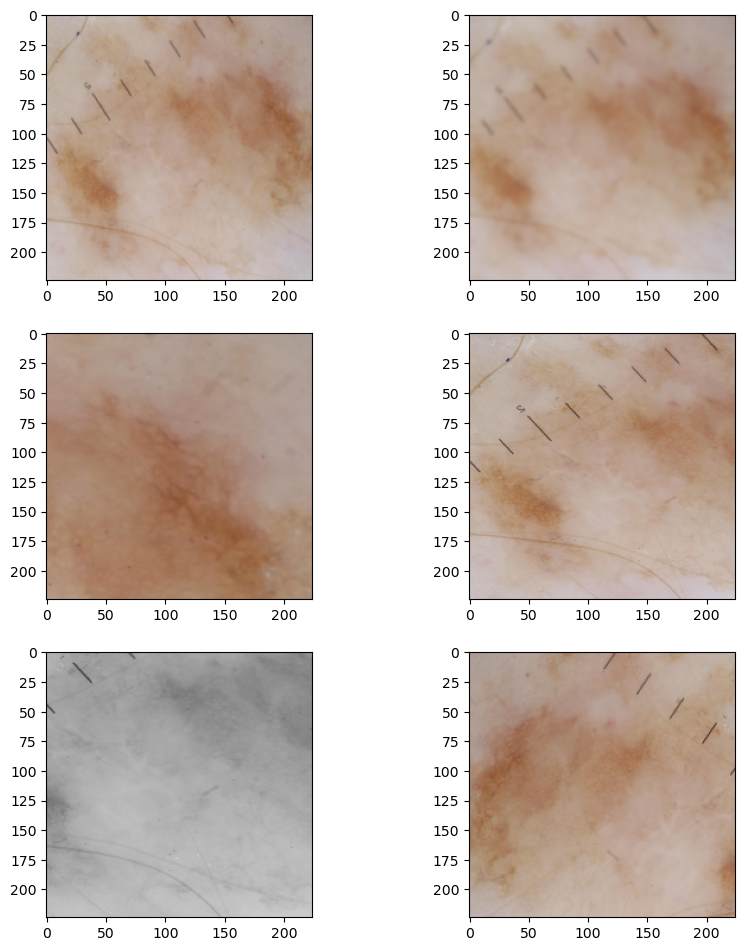

In [7]:
plt.figure(figsize=(10,20))
def view_data(transform_ds, index):
    for i in range(1, 4):
        images = transform_ds[index]
        view1, view2 = images
        plt.subplot(5,2,2*i-1)
        plt.imshow(view1.permute(1,2,0))
        plt.subplot(5,2,2*i)
        plt.imshow(view2.permute(1,2,0))

view_data(train_ds, 2)

## Data loader

In [8]:
BATCH_SIZE = 128

# Building the data loader
train_dl = torch.utils.data.DataLoader(
    train_ds,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=os.cpu_count(),
    drop_last=True,
    pin_memory=True,
)

## SimCLR model

In [9]:
class Identity(nn.Module):
    def __init__(self):
        super(Identity, self).__init__()
    def forward(self, x):
        return x

class SimCLR(nn.Module):
    def __init__(self, linear_eval=False):
        super().__init__()
        self.linear_eval = linear_eval
        resnet18 = models.resnet18(pretrained=False)
        resnet18.fc = Identity()
        self.encoder = resnet18
        self.projection = nn.Sequential(
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, 256)
        )
    def forward(self, x):
        if not self.linear_eval:
            x = torch.cat(x, dim=0)
        
        encoding = self.encoder(x)
        projection = self.projection(encoding) 
        return projection

In [10]:
LABELS = torch.cat([torch.arange(BATCH_SIZE) for i in range(2)], dim=0)
LABELS = (LABELS.unsqueeze(0) == LABELS.unsqueeze(1)).float() # Creates a one-hot with broadcasting
LABELS = LABELS.to(DEVICE) #128,128

def cont_loss(features, temp):
    """
    The NTxent Loss.
    
    Args:
        z1: The projection of the first branch
        z2: The projeciton of the second branch
    
    Returns:
        the NTxent loss
    """
    similarity_matrix = torch.matmul(features, features.T) # 128, 128
    # discard the main diagonal from both: labels and similarities matrix
    mask = torch.eye(LABELS.shape[0], dtype=torch.bool).to(DEVICE)
    # ~mask is the negative of the mask
    # the view is required to bring the matrix back to shape
    labels = LABELS[~mask].view(LABELS.shape[0], -1) # 128, 127
    similarity_matrix = similarity_matrix[~mask].view(similarity_matrix.shape[0], -1) # 128, 127

    # select and combine multiple positives
    positives = similarity_matrix[labels.bool()].view(labels.shape[0], -1) # 128, 1

    # select only the negatives
    negatives = similarity_matrix[~labels.bool()].view(similarity_matrix.shape[0], -1) # 128, 126

    logits = torch.cat([positives, negatives], dim=1) # 128, 127
    labels = torch.zeros(logits.shape[0], dtype=torch.long).to(DEVICE)

    logits = logits / temp
    return logits, labels

In [11]:
LABELS.shape

torch.Size([256, 256])

In [12]:
simclr_model = SimCLR().to(DEVICE)
criterion = nn.CrossEntropyLoss().to(DEVICE)
optimizer = torch.optim.Adam(simclr_model.parameters())

/home/ubuntu/miniconda3/envs/cs230_project_env/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/home/ubuntu/miniconda3/envs/cs230_project_env/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [13]:
EPOCHS = 10
for epoch in range(EPOCHS):
    t0 = time.time()
    running_loss = 0.0
    for i, views in enumerate(train_dl):
        projections = simclr_model([view.to(DEVICE) for view in views])
        logits, labels = cont_loss(projections, temp=2)
        loss = criterion(logits, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # print statistics
        running_loss += loss.item()
        if i % 10 == 9:    # print every 10 mini-batches
            print(f'EPOCH: {epoch+1} BATCH: {i+1} LOSS: {(running_loss/100):.4f} ')
            running_loss = 0.0
    print(f'Time taken: {((time.time()-t0)/60):.3f} mins')

EPOCH: 1 BATCH: 10 LOSS: 0.5204 
EPOCH: 1 BATCH: 20 LOSS: 0.3536 
EPOCH: 1 BATCH: 30 LOSS: 0.3244 
EPOCH: 1 BATCH: 40 LOSS: 0.3007 
EPOCH: 1 BATCH: 50 LOSS: 0.2916 
EPOCH: 1 BATCH: 60 LOSS: 0.2839 
EPOCH: 1 BATCH: 70 LOSS: 0.2615 
EPOCH: 1 BATCH: 80 LOSS: 0.2646 
EPOCH: 1 BATCH: 90 LOSS: 0.2571 
EPOCH: 1 BATCH: 100 LOSS: 0.2518 
EPOCH: 1 BATCH: 110 LOSS: 0.2281 
EPOCH: 1 BATCH: 120 LOSS: 0.2292 
EPOCH: 1 BATCH: 130 LOSS: 0.2303 
EPOCH: 1 BATCH: 140 LOSS: 0.2210 
EPOCH: 1 BATCH: 150 LOSS: 0.2210 
EPOCH: 1 BATCH: 160 LOSS: 0.2177 
EPOCH: 1 BATCH: 170 LOSS: 0.2042 
EPOCH: 1 BATCH: 180 LOSS: 0.1918 
EPOCH: 1 BATCH: 190 LOSS: 0.1982 
EPOCH: 1 BATCH: 200 LOSS: 0.1827 
EPOCH: 1 BATCH: 210 LOSS: 0.1853 
EPOCH: 1 BATCH: 220 LOSS: 0.1853 
EPOCH: 1 BATCH: 230 LOSS: 0.1805 
EPOCH: 1 BATCH: 240 LOSS: 0.1901 
EPOCH: 1 BATCH: 250 LOSS: 0.1747 
Time taken: 14.292 mins


In [28]:
# torch.save(simclr_model.state_dict(), "simclr_weights.pt")

## Downstream task

In [16]:
from torchvision.transforms import (
    CenterCrop,
    Resize
)

In [17]:
resize = Resize(255)
ccrop = CenterCrop(224)
ttensor = ToTensor()

custom_transform = Compose([
    resize,
    ccrop,
    ttensor,
])

train_ds_downstream = ImageFolder(
    root="train",
    transform=custom_transform
)

nu_classes = len(train_ds_downstream.classes)

BATCH_SIZE = 128

# Building the data loader
train_dl_downstream = torch.utils.data.DataLoader(
    train_ds_downstream,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=os.cpu_count(),
    drop_last=True,
    pin_memory=True,
)

In [19]:
class Identity(nn.Module):
    def __init__(self):
        super(Identity, self).__init__()
    def forward(self, x):
        return x

class LinearEvaluation(nn.Module):
    def __init__(self, model, nu_classes):
        super().__init__()
        simclr = model
        simclr.linear_eval = True
        simclr.projection = Identity()
        self.simclr = simclr
        for param in self.simclr.parameters():
            param.requires_grad = False
        self.linear = nn.Linear(512, nu_classes)

    def forward(self, x):
        encoding = self.simclr.encoder(x)
        pred = self.linear(encoding) 
        return pred

In [22]:
eval_model = LinearEvaluation(simclr_model, nu_classes).to(DEVICE)
criterion = nn.CrossEntropyLoss().to(DEVICE)
optimizer = torch.optim.Adam(eval_model.parameters())

In [68]:
EPOCHS = 2
for epoch in range(EPOCHS):
    t0 = time.time()
    running_loss = 0.0
    for i, element in enumerate(train_dl_downstream):
        image, label = element
        print(image.size())
        image = image.to(DEVICE)
        label = label.to(DEVICE)
        pred = eval_model(image)
        loss = criterion(pred, label)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # print statistics
        running_loss += loss.item()
        if i % 10 == 9:    # print every 10 mini-batches
            print(f'EPOCH: {epoch+1} BATCH: {i+1} LOSS: {(running_loss/100):.4f} ')
            running_loss = 0.0
    print(f'Time taken: {((time.time()-t0)/60):.3f} mins')

torch.Size([128, 3, 224, 224])
torch.Size([128, 3, 224, 224])
torch.Size([128, 3, 224, 224])
torch.Size([128, 3, 224, 224])
torch.Size([128, 3, 224, 224])
torch.Size([128, 3, 224, 224])
torch.Size([128, 3, 224, 224])
torch.Size([128, 3, 224, 224])
torch.Size([128, 3, 224, 224])
torch.Size([128, 3, 224, 224])
EPOCH: 1 BATCH: 10 LOSS: 0.0081 
torch.Size([128, 3, 224, 224])
torch.Size([128, 3, 224, 224])
torch.Size([128, 3, 224, 224])
torch.Size([128, 3, 224, 224])
torch.Size([128, 3, 224, 224])
torch.Size([128, 3, 224, 224])
torch.Size([128, 3, 224, 224])
torch.Size([128, 3, 224, 224])
torch.Size([128, 3, 224, 224])
torch.Size([128, 3, 224, 224])
EPOCH: 1 BATCH: 20 LOSS: 0.0050 
torch.Size([128, 3, 224, 224])
torch.Size([128, 3, 224, 224])
torch.Size([128, 3, 224, 224])
torch.Size([128, 3, 224, 224])
torch.Size([128, 3, 224, 224])
torch.Size([128, 3, 224, 224])
torch.Size([128, 3, 224, 224])
torch.Size([128, 3, 224, 224])
torch.Size([128, 3, 224, 224])
torch.Size([128, 3, 224, 224])
EPOC

KeyboardInterrupt: 

## Test data performance

In [64]:
custom_transform = Compose([
    resize,
    ccrop,
    ttensor,
])

test_ds_downstream = ImageFolder(
    root="test",
    transform=custom_transform
)

nu_classes = len(test_ds_downstream.classes)

BATCH_SIZE = 128

# Building the data loader
test_dl_downstream = torch.utils.data.DataLoader(
    test_ds_downstream,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=os.cpu_count(),
    drop_last=True,
    pin_memory=True,
)


# resize = Resize(255)
# ccrop = CenterCrop(224)
# ttensor = ToTensor()

# custom_transform = Compose([
#     resize,
#     ccrop,
#     ttensor,
# ])

# train_ds_downstream = ImageFolder(
#     root="train",
#     transform=custom_transform
# )

# nu_classes = len(train_ds_downstream.classes)

# BATCH_SIZE = 128

# # Building the data loader
# train_dl_downstream = torch.utils.data.DataLoader(
#     train_ds_downstream,
#     batch_size=BATCH_SIZE,
#     shuffle=True,
#     num_workers=os.cpu_count(),
#     drop_last=True,
#     pin_memory=True,
# )

In [65]:
len(test_ds_downstream[0][0])

3

In [71]:
pred_list = []
true_label_list = []
for i, element in enumerate(test_ds_downstream):
    image, label = element
    image = np.expand_dims(image, axis=0)
    image = torch.Tensor(image).to(DEVICE)
    # label = label.to(DEVICE)
    pred = eval_model(image)
    
    pred_list.append(pred)
    true_label_list.append(label)    
    

In [72]:
len(pred_list)

656

In [73]:
len(true_label_list)

656

In [101]:
correct_count = 0
tp = 0
fp = 0
tn = 0
fn = 0

for i, v in enumerate(true_label_list):
    pred = np.argmax(pred_list[i].cpu().detach().numpy())
    true = v


print(correct_count)
print(correct_count/656)
    

485
0.739329268292683
